This simulates the game of life, which consists of an array (board) of cells which can be alive or dead.  They evolve at discrete timesteps according to the following rules:
1. any live cell with fewer than two live neighbours dies (underpopulation)
2. any live cell with two or three live neighbours lives
3. any live cell with more than three live neighbours dies (overpopulation)
4. any dead cell with exactly three live neighbours becomes live (reproduction)


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from matplotlib.colors import ListedColormap, BoundaryNorm
import random as rd

In [12]:
def new_board(board_size, preset = 0, tree_density = None, dirt_cells = None):
    '''
    preset 0
    100% density forest

    preset 1
    perlin noise > random 0,1 dirt cells decided forest

    preset 2
    river

    preset 3
    lakes

    preset 4
    
    '''
    filled_board = np.zeros(board_size)

    if preset == 0:
        return filled_board
    
    elif preset == 1:
        filled_board[dirt_cells > 1-tree_density] = 10
        return filled_board
    

#height map
        

In [13]:
# def random_board(board_size):
#     '''
#     Set up a random board where a cell is alive with probability p
#     '''
#     board = new_board(board_size)
    
#     random_row = np.random.randint(0, board.shape[0])
#     random_col = np.random.randint(0, board.shape[1])

#     # Assign the new value to the randomly chosen position
#     board[random_row, random_col] = 1
#     return board

def fire_board(board, fire_type = 0, fire_pos = ((0,0), (0,1), (1,0), (1,1)), p = 0.001):
    if fire_type == 0:
        for x, y in fire_pos:
            board[x,y] = 1
    
    if fire_type == 1:
        random_cells = np.random.rand(board.shape[0],board.shape[1])
        board[random_cells > 1-p] = 1
        
    return board

In [ ]:
def plot_board(board):
    ''' 
    Plot a board with specific colors for each value:
    - lime green for 0 (flammable)
    - red for 1 (burning)
    - grey for 0.1 (burnt)
    - dark green for regrowing (0.01, 0.02, 0.03, 0.04, 0.05)
    '''
    # Define the color map with four colors
    cmap = ListedColormap([ 'darkgreen', 'darkseagreen', 'grey', 'red', 'saddlebrown', 'black'])
    
    boundaries = [0, 10**(-10), 0.099, 0.15, 9, 15, 150]  # Boundaries to separate the color intervals
    norm = BoundaryNorm(boundaries, cmap.N)  # Use norm to map boundaries to cmap indices
    
    # Plot with custom color map and boundaries
    img = plt.imshow(board, cmap=cmap, norm=norm)
    return img

In [15]:
# def get_cell(board,row,col):
#     '''
#     Return the value of the cell at (row,col) in board, modulo the size of the board
#     '''
#     return board[row % board.shape[0],col % board.shape[1]]

def get_cell(board, row, col):
    '''
    Return the value of the cell at (row, col) in board, with non-periodic boundaries.
    If (row, col) is out of bounds, return 0 (considered as non-flammable).
    '''
    if row < 0 or row >= board.shape[0] or col < 0 or col >= board.shape[1]:
        return 100 # Out of bounds cells are treated as non-flammable
    return board[row, col]

In [16]:
# def set_cell(board,row,col,value):
#     '''
#     Assign the given value to the cell at (row,col) in board, modulo the size of the board
#     '''
#     board[row % board.shape[0],col % board.shape[1]] = value
#     return board

def set_cell(board, row, col, value):
    '''
    Assign the given value to the cell at (row, col) in board, with non-periodic boundaries.
    If (row, col) is out of bounds, do nothing.
    '''
    if 0 <= row < board.shape[0] and 0 <= col < board.shape[1]:
        board[row, col] = value
    return board

In [17]:
# def count_neighbours(board,row,col):
#     '''
#     Count the number of alive neighbours of cell at (row,col), with periodic boundary conditions
#     (implemented through get_cell)
#     '''
#     if row % 2 == 0:
#         return(                               + get_cell(board,row-1,col) + get_cell(board,row-1,col+1)
#                 + get_cell(board,row,col-1)                               + get_cell(board,row,col+1)
#                                               + get_cell(board,row+1,col) + get_cell(board,row+1,col+1))
#     else:
#         return(  get_cell(board,row-1,col-1) + get_cell(board,row-1,col) 
#                + get_cell(board,row,col-1)                               + get_cell(board,row,col+1)
#                + get_cell(board,row+1,col-1) + get_cell(board,row+1,col) ) 
    

    

def num_burning_neighbours(board, row, col, wind_ang = None):
    '''
    Count the number of burning neighbors (cells with value 1) around a cell at (row, col).
    '''
    burning_count = 0
    importance = 0

    neighbours = [
                        (row-2, col-1), (row-2, col), (row-2, col+1),
        (row-1, col-2), (row-1, col-1), (row-1, col), (row-1, col+1), (row-1, col+2),
        (row  , col-2), (row  , col-1),               (row  , col+1), (row  , col+2),
        (row+1, col-2), (row+1, col-1), (row+1, col), (row+1, col+1), (row+1, col+2),
                        (row+2, col-1), (row+2, col), (row+2, col+1)
    ]

    
    
    if wind_ang == None:
        neighbours = neighbours[4:7] + neighbours[9:11] + neighbours[13:16]

        if row % 2 == 0:
            del neighbours[0]
            del neighbours[5-1] #shifted left index due to previous deletion, similar for other -1
        else:
            del neighbours[2]
            del neighbours[7-1]

        # Count burning cells (value = 1) in the neighboring positions
        for i, val in enumerate(neighbours):
            r, c = val[0], val[1]
            if 0 <= r < board.shape[0] and 0 <= c < board.shape[1]:  # Check bounds
                if 1 <= get_cell(board, r, c) <= 2:  # Only count burning cells
                    burning_count += 1
    
    else:
        
        if row % 2 == 0:
            neighbours[4] = neighbours[3]
            neighbours[13] = neighbours[12]
            del neighbours[3]
            del neighbours[12-1]

            outer_list = [neighbours[10], neighbours[6], neighbours[2], neighbours[1], 
                            neighbours[0], neighbours[3], neighbours[7], neighbours[11], 
                            neighbours[15], neighbours[16], neighbours[17], neighbours[14]]
            
            inner_list = [neighbours[5], neighbours[4], neighbours[8], neighbours[9], neighbours[12], neighbours[13]]
            
            neighbours = inner_list + outer_list[wind_ang//30-1:(wind_ang//30+1)+1]

        else:
            neighbours[6] = neighbours[7]
            neighbours[15] = neighbours[16]
            del neighbours[7]
            del neighbours[16-1]

            outer_list = [neighbours[10], neighbours[6], neighbours[2], neighbours[1], 
                            neighbours[0], neighbours[3], neighbours[7], neighbours[11], 
                            neighbours[15], neighbours[16], neighbours[17], neighbours[14]]
            
            inner_list = [neighbours[5], neighbours[4], neighbours[8], neighbours[9], neighbours[12], neighbours[13]]

            neighbours = inner_list + outer_list[wind_ang//30-1:(wind_ang//30+1)+1]

        # Count burning cells (value = 1) in the neighboring positions
        for i, val in enumerate(neighbours):
            r, c = val[0], val[1]
            if 0 <= r < board.shape[0] and 0 <= c < board.shape[1]:  # Check bounds
                if 1 <= get_cell(board, r, c) <= 2:  # Only count burning cells
                    burning_count += 1
                    
                    if round(((wind_ang-180)%360 + 15)/60) == round(((wind_ang-180)%360 - 15)/60):
                        if i == ((wind_ang-180)%360)//60:
                            importance -= 1
                    else:   
                        if i == round(((wind_ang-180)%360 + 15)/60):
                            importance -= 0.5
                        elif i == round(((wind_ang-180)%360 - 15)/60):
                            importance -= 0.5
                            

    
    
    
    
    return burning_count, importance





# def count_neighbours(board,row,col):
#     '''
#     Count the number of alive neighbours of cell at (row,col), with periodic boundary conditions
#     (implemented through get_cell)
#     '''
#     return(  get_cell(board,row-1,col-1) + get_cell(board,row-1,col) + get_cell(board,row-1,col+1)
#            + get_cell(board,row,col-1)                               + get_cell(board,row,col+1)
#            + get_cell(board,row+1,col-1) + get_cell(board,row+1,col) + get_cell(board,row+1,col+1))


    

In [18]:
def step(board, preset = 0, tree_density = None, tree_cells = None, wind_ang = None):
    '''
    Creates the next iteration from a given board
    '''
    
    # create an empty board to store the new result in
    next_board = new_board(board.shape, preset, tree_density, tree_cells)
    
    # loop over each row and column
    for row in range(0, board.shape[0]):
        for col in range(0, board.shape[1]):
            
            # determine the number of neighbours that are flammable
            burning_neighbours, imp = num_burning_neighbours(board, row, col, wind_ang)

            cell_value = get_cell(board, row, col)

            # determine if the cell is flammable
            is_flammable = cell_value == 0

            prob_fire = rd.random()
            
            for i in range(1,18+1):
                # with rlly low values of p and high time duration, interesting impact on animation

                if imp == -1:
                    spread_chance = (1-0.5)**(i**(1/2))
                else:
                    spread_chance = (1-0.75)**(i**(1/2))

                if burning_neighbours >= i and is_flammable and prob_fire >= spread_chance: # taking 75% fire spread chance
                    set_cell(next_board, row, col, 1)
            if cell_value == 1:
                set_cell(next_board, row, col, 0.1)

            for i in range(1,2):
                if cell_value == 1*i:
                    set_cell(next_board, row, col, 1*(i+1))
                elif cell_value == 1*(2):
                    set_cell(next_board, row, col, 0.1)
            
            if cell_value == 0.1:
                set_cell(next_board, row, col, 0.001)

            # i=0
            # while i <= 50:
            #     i+=1
            #     if cell_value <= -1 and cell_value > -(30):
            #         set_cell(next_board, row, col, cell_value - 1)
            #     elif cell_value == -(30):  # Timer reaches zero
            #         set_cell(next_board, row, col, 0)  # Reset to flammable


            for i in range(1,75):
                if cell_value == 0.001*i:
                    set_cell(next_board, row, col, 0.001*(i+1))
                elif cell_value == 0.001*(75):
                    set_cell(next_board, row, col, 0)
                
    return next_board

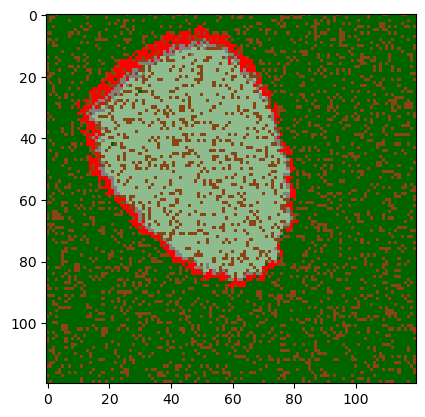

KeyboardInterrupt: 

In [19]:
n_steps = 100
board_size = 120

dirt_cells = np.random.rand(board_size,board_size)

preset, tree_density = 1, 0.2
no_fire_board = new_board([board_size,board_size], preset, tree_density, dirt_cells)

fire_type, fire_pos, p = 0, ((60,60),(60,61),(61,60),(61,61)), 0.0001
board = fire_board(no_fire_board, fire_type, fire_pos, p)
fig, ax = plt.subplots()
img = plot_board(board)

wind_ang = 300

for i_step in range(n_steps):
    img.set_array(board)
    plt.pause(0.1)
    clear_output(wait=True)
    display(fig)

    board = step(board, preset, tree_density, dirt_cells, wind_ang)

    if i_step == 10:
        np.save('grid.npy', board)

